## Speed-run RNN in 50 mins

In [1]:
import torch
import torch.nn as nn

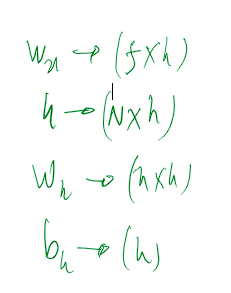

In [2]:
class LinearLayer(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.weight = torch.nn.Parameter(torch.rand(in_features, out_features))
        self.bias = torch.nn.Parameter(torch.rand(out_features))

    def forward(self, x: torch.tensor):
        return x @ self.weight + self.bias

class RNNCell(nn.Module):
    def __init__(self, in_features: int, hidden_features: int):
        super().__init__()
        self.hidden_features = hidden_features
        self.weight_x = nn.Parameter(torch.rand(in_features, hidden_features))
        self.weight_h = nn.Parameter(torch.rand(hidden_features, hidden_features))
        self.bias_h = nn.Parameter(torch.rand(hidden_features))
    
    def forward(self, x: torch.torch, h_prev: torch.tensor):
        if h_prev is None:
            h_prev = torch.ones(x.shape[0], self.hidden_feature)
        return torch.tanh(x @ self.weight_x + h_prev @ self.weight_h + self.bias_h)

class LayerNorm(nn.Module):
    def __init__(self, in_features: int, eps: float = 0.001):
        super().__init__()
        self.in_features = in_features
        self.eps = eps

        self.gamma = nn.Parameter(torch.ones(self.in_features))
        self.beta = nn.Parameter(torch.zeros(self.in_features))
    
    def forward(self, x: torch.torch):
        x_mean = x.mean(dim = 1, keepdim = True)
        x_var = x.var(dim = 1, keepdim = True, unbiased = False)
        x_norm = (x - x_mean) / ((x_var + self.eps) ** 0.5)
        return x_norm * self.gamma + self.beta

class RNN(nn.Module):
    def __init__(self, in_features: int, hidden_features: int, out_feature: int, eps: float = 0.001):
        super().__init__()

        self.rnn_cell = RNNCell(in_features = in_features, hidden_features = hidden_features)
        self.layer_norm = LayerNorm(in_features = hidden_features)
        self.linear_transformation_layer = LinearLayer(in_features = hidden_features, out_features = out_feature)

        self.hidden_features = hidden_features

    
    def forward(self, x: torch.torch, h_prev: torch.tensor):
        if h_prev is None:
            h_prev = torch.ones(x.shape[0], self.hidden_features)
        
        h_t = h_prev
        batch, seq_length, feature = x.shape
        outputs = []
        for t in range(seq_length):
            x_t = x[:, t]
            h_t = self.rnn_cell(x_t, h_t)
            h_t = self.layer_norm(h_t)
            logits = self.linear_transformation_layer(h_t)
            outputs.append(logits)
        
        return torch.stack(outputs, dim = 1)


In [3]:
x = torch.randint(low = 0, high = 27, size = (10, 5))
y_true = torch.randint(low = 0, high = 27, size = (10, 5))
embeddings = torch.rand(27, 3)
x_enc = embeddings[x]
h_prev = None
rnn = RNN(in_features = x_enc.shape[-1], hidden_features = 8, out_feature = 27, eps = 0.01)

optimizer = torch.optim.Adam(params = rnn.parameters(), lr = 0.01)

import torch.nn.functional as F

def train_model(model, epochs: int):
    for epoch in range(epochs):
        logits = rnn(x_enc, h_prev)
        loss = F.cross_entropy(
            input = logits.view(-1, 27),
            target = y_true.view(-1)
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(loss)

In [4]:
train_model(rnn, epochs = 10000)

tensor(3.5754, grad_fn=<NllLossBackward0>)
tensor(1.0197, grad_fn=<NllLossBackward0>)
tensor(0.6626, grad_fn=<NllLossBackward0>)
tensor(0.5798, grad_fn=<NllLossBackward0>)
tensor(0.5534, grad_fn=<NllLossBackward0>)
tensor(0.5398, grad_fn=<NllLossBackward0>)
tensor(0.5248, grad_fn=<NllLossBackward0>)
tensor(0.4609, grad_fn=<NllLossBackward0>)
tensor(0.4271, grad_fn=<NllLossBackward0>)
tensor(0.3889, grad_fn=<NllLossBackward0>)
tensor(0.4766, grad_fn=<NllLossBackward0>)
tensor(0.3766, grad_fn=<NllLossBackward0>)
tensor(0.3263, grad_fn=<NllLossBackward0>)
tensor(0.2846, grad_fn=<NllLossBackward0>)
tensor(0.2436, grad_fn=<NllLossBackward0>)
tensor(0.2034, grad_fn=<NllLossBackward0>)
tensor(0.1661, grad_fn=<NllLossBackward0>)
tensor(0.1298, grad_fn=<NllLossBackward0>)
tensor(0.0971, grad_fn=<NllLossBackward0>)
tensor(0.1835, grad_fn=<NllLossBackward0>)
tensor(0.1100, grad_fn=<NllLossBackward0>)
tensor(0.0864, grad_fn=<NllLossBackward0>)
tensor(0.0722, grad_fn=<NllLossBackward0>)
tensor(0.06